In [3]:
from netCDF4 import Dataset as NetCDFFile
import numpy as np
from numpy import matlib
import scipy.signal
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
from matplotlib import colors
import xarray as xr
from numpy import meshgrid
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.font_manager import findfont, FontProperties
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
font = findfont(FontProperties(family=['sans-serif']))
font

'/System/Library/Fonts/LucidaGrande.ttc'

In [18]:
owda = xr.open_dataset('owda_hd_fix_500.nc').pdsi.transpose('time','lon','lat').sel(time=slice(1901,2012))
precip = xr.open_dataset('cru_ts4.03.1901.2018.pre.dat.nc').pre.transpose('time','lon','lat')[0:1344,:,:].sel(lon=slice(-11.75,44.75)).sel(lat=slice(27.25,70.75))
pp = np.zeros((12,114,88));
for x in range(12):
    for y in range(114):
        for z in range(88):
            pp[x,y,z] = scipy.stats.pearsonr(precip[x::12,y,z],owda[:,y,z])[0]

np.save('pp_OWDA_precip',pp)


In [19]:
pp = np.load('pp_OWDA_precip.npy')
pp2 = np.zeros((12,114,88))
for y in range(0,88):
    pp2[:,:,y] = pp[:,:,y]*np.array(np.cos(np.radians(owda.lat[y])))
np.nanmean(np.nanmean(pp2,axis=2),axis=1)#shows precip-OWDA correlation is highest in MJJ 

array([0.08312567, 0.10108119, 0.1079871 , 0.09659988, 0.13880117,
       0.17431083, 0.1642874 , 0.11315986, 0.03383694, 0.05485682,
       0.01394179, 0.03058019])

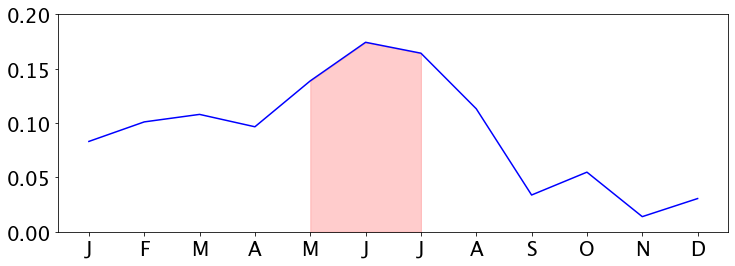

In [23]:
plt.figure(figsize=(12,4))

pp2_mean = np.nanmean(np.nanmean(pp2,axis=2),axis=1)
line1 = plt.plot(pp2_mean,label='Monthly Correlation',color='blue')

plt.ylim((0,0.2))
xval = ['J','F','M','A','M','J','J','A','S','O','N','D']
x = [0,1,2,3,4,5,6,7,8,9,10,11,12]

plt.xticks(x,xval);

x1 = [4,5,6]
y1 = [pp2_mean[4],pp2_mean[5],pp2_mean[6]]
plt.fill_between(x1, y1,
                 color='red',       # The outline color
                 alpha=0.2)          # Transparency of the fill

plt.tick_params(axis='both',which = 'major', labelsize=20)

In [24]:
may = xr.open_dataset('cru_ts4.03.1901.2018.pre.dat.nc').pre.transpose('time','lon','lat')[4::12,:,:].sel(lon=slice(-11.75,44.75)).sel(lat=slice(27.25,70.75))
june = xr.open_dataset('cru_ts4.03.1901.2018.pre.dat.nc').pre.transpose('time','lon','lat')[5::12,:,:].sel(lon=slice(-11.75,44.75)).sel(lat=slice(27.25,70.75))
july = xr.open_dataset('cru_ts4.03.1901.2018.pre.dat.nc').pre.transpose('time','lon','lat')[6::12,:,:].sel(lon=slice(-11.75,44.75)).sel(lat=slice(27.25,70.75))

mjj = (np.array(may[0:112])+np.array(june[0:112])+np.array(july[0:112]))/3

for x in range(0,114):
    for y in range(0,88):
        if mjj[0,x,y] == np.nan:
            mjj[:,x,y] = np.nan
        else:
            continue

owda = xr.open_dataset('owda_hd_fix_500.nc').pdsi.transpose('time','lon','lat').sel(time=slice(1901,2012))
owda2 = np.array(owda.sel(time=slice(1901,2012)))
for x in range(0,114):
    for y in range(0,88):
        if owda2[0,x,y] == np.nan:
            owda2[:,x,y] = np.nan
        else:
            continue

In [25]:
pp = np.zeros((114,88))
for x in range(0,114):
    for y in range(0,88):
        pp[x,y] = np.corrcoef(owda2[:,x,y],mjj[:,x,y])[0][1]
        

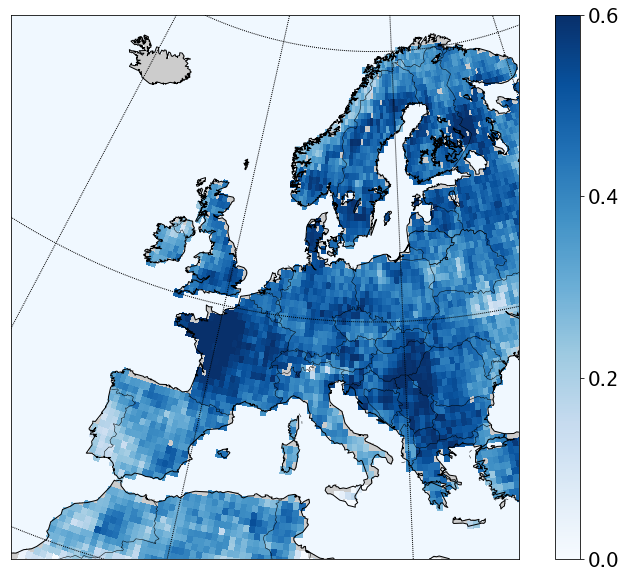

In [26]:
xx,yy=meshgrid(owda.lat,owda.lon)
font = findfont(FontProperties(family=['sans-serif']))

data=pp
    
plt.figure(figsize=(15,10))
map = Basemap(projection='aea',lat_0=49.25,lon_0=16.75,llcrnrlon=-11.75,llcrnrlat=27.75,urcrnrlon=44.75,urcrnrlat=70.75,resolution='l')
map.drawcoastlines()
map.drawcountries()
map.drawlsmask(ocean_color='aliceblue')
parallels = np.arange(30,90,20)
meridians = np.arange(-20,60,20)
map.drawparallels(parallels)
map.drawmeridians(meridians)
map.pcolormesh(yy-0.5,xx-0.5,np.array(data),cmap='Blues',latlon=True, vmin=0, vmax=0.6)

cbar = map.colorbar(location='right',pad=0.5)
cbar.ax.tick_params(labelsize=20) 
cbar.set_ticks([0,0.2,0.4,0.6])



In [46]:
from eofs.standard import Eof
coslat = np.expand_dims(np.expand_dims(np.cos(np.radians(owda.lat)),axis=0),axis=1)
wght1 = np.sqrt(np.tile(coslat,[112,114,1]))

solver={};pc={};eof={};eigen={};variance={};
solver = Eof(owda2,weights = wght1)
eof = solver.eofs(eofscaling=2,neofs=5)
pc = solver.pcs(npcs=50, pcscaling=1)
variance = solver.varianceFraction()
print(variance[0:5])


[0.1487467  0.11645402 0.07615501 0.06740908 0.04668665]


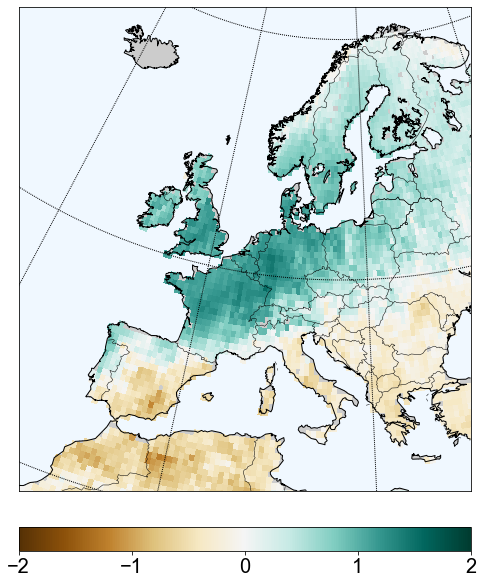

In [47]:
data=np.squeeze(eof[1,:,:]*-1)#0 for EOF1, 1 for EOF2
    
plt.figure(figsize=(15,10))
#plt.title('EOF1',size=20)
map = Basemap(projection='aea',lat_0=49.25,lon_0=16.75,llcrnrlon=-11.75,llcrnrlat=27.75,urcrnrlon=44.75,urcrnrlat=70.75,resolution='l')
map.drawcoastlines()
map.drawcountries()
map.drawlsmask(ocean_color='aliceblue')
parallels = np.arange(30,90,20)
meridians = np.arange(-20,60,20)
map.drawparallels(parallels)
map.drawmeridians(meridians)
map.pcolormesh(yy-0.5,xx-0.5,np.array(data),cmap='BrBG',latlon=True, vmin=-2, vmax=2)
cbar = map.colorbar(location='bottom',pad=0.5)
cbar.ax.tick_params(labelsize=20)


In [48]:
import reverse_geocode
#Country Masks
UK_mask = np.zeros((114,88));France_mask = np.zeros((114,88));Germany_mask = np.zeros((114,88));
Switzerland_mask = np.zeros((114,88));Austria_mask = np.zeros((114,88));Belgium_mask = np.zeros((114,88));
Netherlands_mask = np.zeros((114,88));Luxembourg_mask = np.zeros((114,88));Italy_mask = np.zeros((114,88));
Europe_mask = np.zeros((114,88)); Europe_mask[:,:] = np.nan

for x in range(0,114):
    for y in range(0,88):
        coordinates = (owda.lat[y], owda.lon[x]), 
        if 'United Kingdom' in str(reverse_geocode.search(coordinates)):
            UK_mask[x,y] = 1
            Europe_mask[x,y] = 1
        else:
            UK_mask[x,y] = np.nan
            
        if 'France' in str(reverse_geocode.search(coordinates)):
            France_mask[x,y] = 1
            Europe_mask[x,y] = 1
        else:
            France_mask[x,y] = np.nan

        if 'Germany' in str(reverse_geocode.search(coordinates)):
            Germany_mask[x,y] = 1
            Europe_mask[x,y] = 1
        else:
            Germany_mask[x,y] = np.nan

        if 'Switzerland' in str(reverse_geocode.search(coordinates)):
            Switzerland_mask[x,y] = 1
        else:
            Switzerland_mask[x,y] = np.nan

        if 'Austria' in str(reverse_geocode.search(coordinates)):
            Austria_mask[x,y] = 1
            Europe_mask[x,y] = 1
        else:
            Austria_mask[x,y] = np.nan

        if 'Belgium' in str(reverse_geocode.search(coordinates)):
            Belgium_mask[x,y] = 1
            Europe_mask[x,y] = 1
        else:
            Belgium_mask[x,y] = np.nan
            
        if 'Netherlands' in str(reverse_geocode.search(coordinates)):
            Netherlands_mask[x,y] = 1
            Europe_mask[x,y] = 1
        else:
            Netherlands_mask[x,y] = np.nan

        if 'Luxembourg' in str(reverse_geocode.search(coordinates)):
            Luxembourg_mask[x,y] = 1
            Europe_mask[x,y] = 1
        else:
            Luxembourg_mask[x,y] = np.nan
            
        if 'Italy' in str(reverse_geocode.search(coordinates)):
            Italy_mask[x,y] = 1
        else:
            Italy_mask[x,y] = np.nan
            

In [49]:
Europe = owda.sel(time=slice(1901,2012))*np.tile(np.expand_dims(Europe_mask,axis=0),[112,1,1])
for y in range(0,88):
    Europe[:,:,y] = Europe[:,:,y]*np.cos(np.radians(owda.lat[y]))#area-weight
Europe = np.nanmean(np.nanmean(Europe,axis=2),axis=1)
   

In [52]:
pc1 = pc[:,0]*-1; 
pc2 = pc[:,1]*-1;

Text(0, 0.5, 'PDSI')

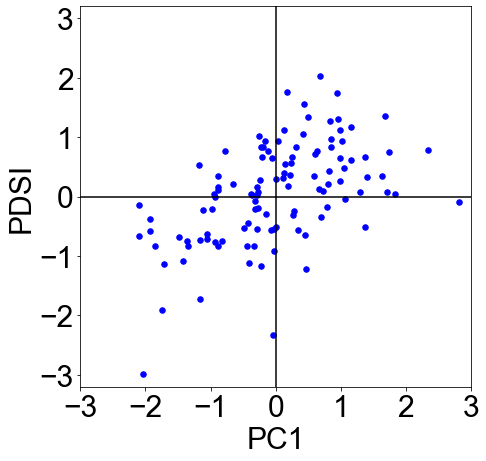

In [53]:
# Say, "the default sans-serif font is COMIC SANS"
plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "Arial"


fig = plt.figure(figsize=(7,7))
x1 = pc1 #replace with pc2 for PC2;
y1 = Europe
plt.scatter(x1,y1,s=30,marker='o',c='blue')
plt.xlim([-3,3]);plt.xticks([-3,-2,-1,0,1,2,3]) 
plt.ylim([-3.2,3.2]);plt.yticks([-3,-2,-1,0,1,2,3])

plt.plot([-5, 5],[0, 0],'k',3.5)
plt.plot([0,0],[-5,5],'k',3.5)
plt.tick_params(axis='both', which='major', labelsize=30)

plt.xlabel('PC1',size=30)#replace with PC2 for PC2
plt.ylabel('PDSI',size=30)



In [54]:
from eofs.standard import Eof
coslat = np.expand_dims(np.expand_dims(np.cos(np.radians(may.lat)),axis=0),axis=1)
wght1 = np.sqrt(np.tile(coslat,[112,114,1]))
solver={};pc={};eof={};eigen={};variance={};
solver = Eof(mjj,weights = wght1)
eof = solver.eofs(eofscaling=2,neofs=5)
pc = solver.pcs(npcs=50, pcscaling=1)
variance = solver.varianceFraction()
print(variance[0:5])


[0.14675394 0.12648524 0.09529617 0.0805861  0.05219596]


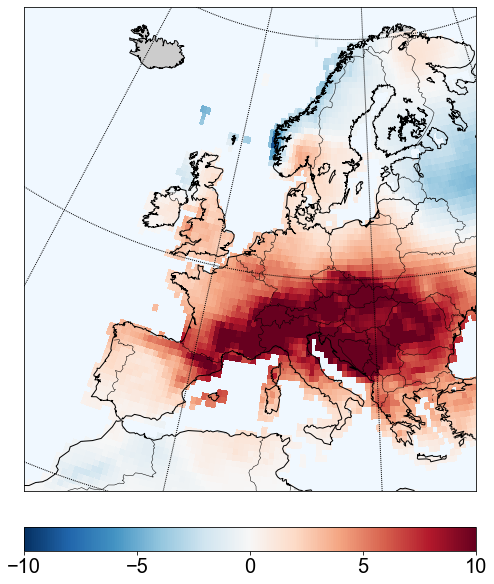

In [55]:
data=np.squeeze(eof[0,:,:])#0 for EOF1, 1 for EOF2
    
plt.figure(figsize=(15,10))
map = Basemap(projection='aea',lat_0=49.25,lon_0=16.75,llcrnrlon=-11.75,llcrnrlat=27.75,urcrnrlon=44.75,urcrnrlat=70.75,resolution='l')
map.drawcoastlines()
map.drawcountries()
map.drawlsmask(ocean_color='aliceblue')
parallels = np.arange(30,90,20)
meridians = np.arange(-20,60,20)
map.drawparallels(parallels)
map.drawmeridians(meridians)
map.pcolormesh(yy-0.5,xx-0.5,np.array(data),cmap='RdBu_r',latlon=True, vmin=-10, vmax=10)
cbar = map.colorbar(location='bottom',pad=0.5)
cbar.ax.tick_params(labelsize=20)


In [56]:
Europe = mjj*np.tile(np.expand_dims(Europe_mask,axis=0),[112,1,1])
for y in range(0,88):
    Europe[:,:,y] = Europe[:,:,y]*np.array(np.cos(np.radians(owda.lat[y])))#area-weight
Europe = np.nanmean(np.nanmean(Europe,axis=2),axis=1)

In [57]:
pc1 = pc[:,0]; 
pc2 = pc[:,1];

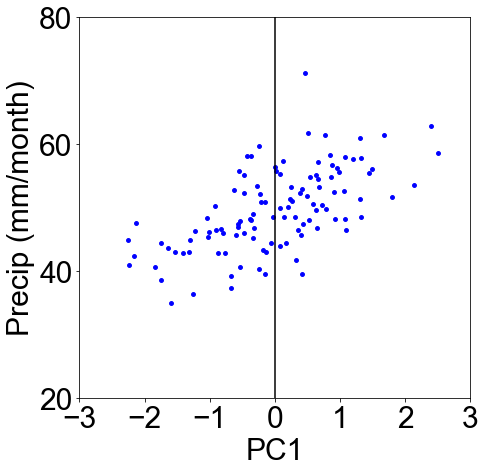

In [59]:
# Say, "the default sans-serif font is COMIC SANS"
plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "Arial"


fig = plt.figure(figsize=(7,7))
x1 = pc1 #replace pc1 with pc2 for PC2
y1 = Europe
plt.scatter(x1,y1,s=15,marker='o',c='blue')
plt.xlim([-2.75,2.75]);plt.xticks([-3,-2,-1,0,1,2,3]) 
plt.ylim([20,80]);plt.yticks([20,40,60,80])

plt.plot([0,0],[20,80],'k',3.5)
plt.tick_params(axis='both', which='major', labelsize=30)

plt.xlabel('PC1',size=30)#replace with PC2 for PC2
plt.ylabel('Precip (mm/month)',size=30)
plt.savefig('Precip_PC2.eps', format='eps')   


In [ ]:
#calculate spatial correlations

In [77]:
a = solver.eofs(eofscaling=2,neofs=5)*np.sqrt(np.tile(coslat,[5,114,1]))

In [79]:
b = solver.eofs(eofscaling=2,neofs=5)*np.sqrt(np.tile(coslat,[5,114,1]))

In [13]:
print(variance[0:5])


[0.14675392 0.12648524 0.09529617 0.0805861  0.05219596]


In [81]:
import numpy.ma as ma
#spatial correlation
aa = np.reshape(a[1,:,:],114*88)
bb = np.reshape(b[1,:,:],114*88)
print(ma.corrcoef(ma.masked_invalid(aa), ma.masked_invalid(bb)))

[[1.0 -0.8042500349098411]
 [-0.8042500349098411 1.0]]
